In [45]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model
from art.attacks.extraction import KnockoffNets
from art.attacks.evasion import FastGradientMethod
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from art.estimators.classification import KerasClassifier
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

tf.compat.v1.disable_eager_execution()

# Parte 1

In [7]:
# Se abre la carpeta que contiene los archivos a tratar
path = './malimg_dataset/malimg_paper_dataset_imgs/'

In [8]:
familias = ImageDataGenerator().flow_from_directory(directory=path, target_size=(64,64), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [9]:
familias.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [10]:
imgs, labels = next(familias)

In [11]:
imgs.shape

(9339, 64, 64, 3)

In [12]:
labels.shape

(9339, 25)

In [13]:
# Plots de imagenes con etiquetas 
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(familias.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

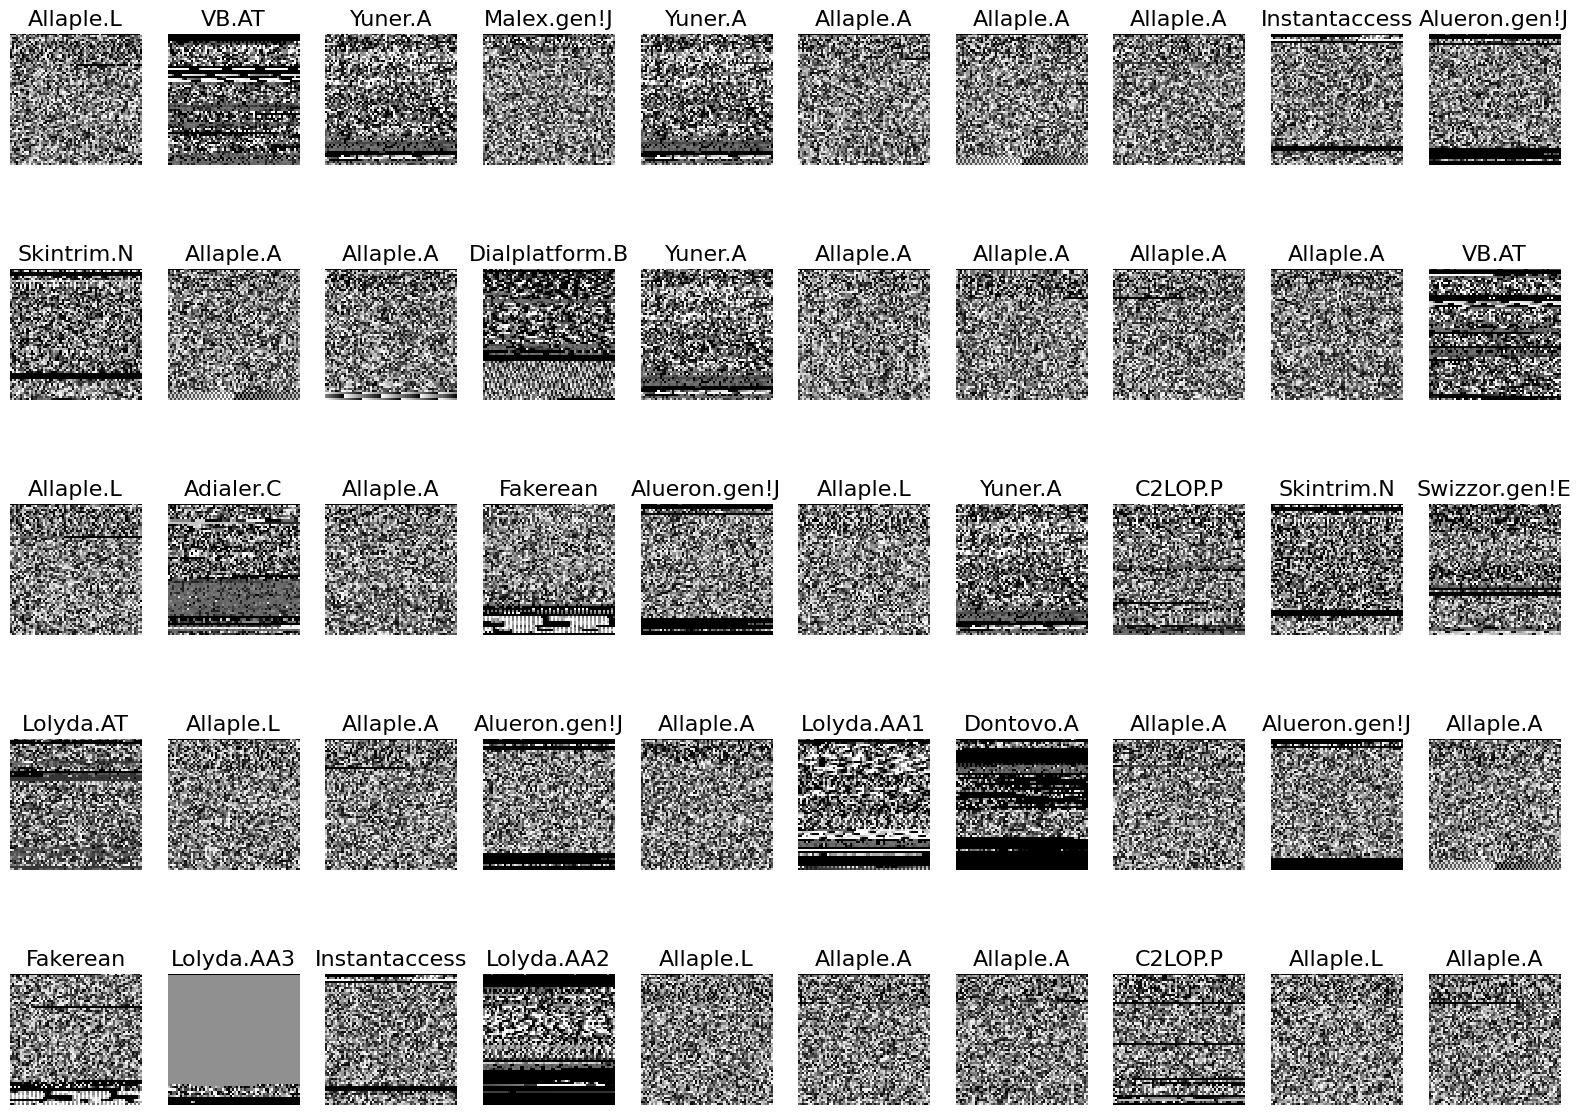

In [14]:
plots(imgs, titles = labels)

# Parte 2

In [16]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(imgs, labels, test_size=0.3, random_state=42)

# Normalizar las imágenes
X_train = X_train / 255.0
X_test = X_test / 255.0

In [17]:
# Definir el modelo
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(25, activation='softmax')
])

# Compilar el modelo
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Train on 6537 samples, validate on 2802 samples
Epoch 1/5
6537/6537 [==============================] - ETA: 0s - loss: 1.2200 - accuracy: 0.6283

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6537/6537 [==============================] - 57s 9ms/sample - loss: 1.2200 - accuracy: 0.6283 - val_loss: 0.5614 - val_accuracy: 0.8633
Epoch 2/5
6537/6537 [==============================] - 48s 7ms/sample - loss: 0.3367 - accuracy: 0.9078 - val_loss: 0.2590 - val_accuracy: 0.9261
Epoch 3/5
6537/6537 [==============================] - 51s 8ms/sample - loss: 0.2100 - accuracy: 0.9394 - val_loss: 0.2352 - val_accuracy: 0.9279
Epoch 4/5
6537/6537 [==============================] - 50s 8ms/sample - loss: 0.1560 - accuracy: 0.9518 - val_loss: 0.1669 - val_accuracy: 0.9483
Epoch 5/5
6537/6537 [==============================] - 54s 8ms/sample - loss: 0.1158 - accuracy: 0.9631 - val_loss: 0.1457 - val_accuracy: 0.9557


In [20]:
# Guardamos el modelo
model.save('malware_classifier_model.h5')
model.save('malware_classifier_model')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
# Abrimos el modelo
tf.compat.v1.disable_eager_execution()
model = load_model('malware_classifier_model.h5')
classifier = KerasClassifier(model=model)

# Hacer predicciones en el conjunto de datos de prueba usando el modelo original
predictions_original = model.predict(X_test)
test_acc_original = np.mean(np.argmax(predictions_original, axis=1) == np.argmax(y_test, axis=1))
print('Test accuracy of original model:', test_acc_original)

Test accuracy of original model: 0.9557458957887224


## Ataque de envenenamiento

El ataque de envenenamiento, es como tal, modificar intencionadamente el conjunto de datos de entrenamiento del modelo introduciendo muestras maliciosas o adversarias. El objetivo es influir en el comportamiento del modelo durante el entrenamiento para que se vuelva menos confiable o incluso inútil en el entorno real. En este caso, veremos una disminución significativa en la precisión del modelo después del ataque de envenenamiento, lo que demuestra su efectividad para comprometer la integridad del modelo.

In [42]:
# Generar muestras de malware falsas para envenenar el conjunto de datos de entrenamiento
num_poisoned_samples = 100
poisoned_samples = np.random.rand(num_poisoned_samples, 64, 64, 3)
poisoned_labels = np.ones((num_poisoned_samples, 25))

# Agregar las muestras envenenadas al conjunto de datos de entrenamiento original
X_train_poisoned = np.concatenate((X_train, poisoned_samples), axis=0)
y_train_poisoned = np.concatenate((y_train, poisoned_labels), axis=0)

# Reentrenar el modelo con el conjunto de datos envenenado
classifier.fit(X_train_poisoned, y_train_poisoned, batch_size=32, nb_epochs=5)

In [44]:
# Hacer predicciones en el conjunto de datos de prueba usando el modelo envenenado
predictions_poisoned = classifier.predict(X_test)
test_acc_poisoned = np.mean(np.argmax(predictions_poisoned, axis=1) == np.argmax(y_test, axis=1))
print('Test accuracy of poisoned model:', test_acc_poisoned)

Test accuracy of poisoned model: 0.010706638115631691


El resultado del modelo original muestra una alta precisión del 95.57%, indicando su eficacia para clasificar correctamente las muestras de prueba. Sin embargo, tras el ataque de entrenamiento, la precisión del modelo envenenado disminuyó drásticamente al 1.07%, lo que lo hace prácticamente inútil para clasificar adecuadamente las muestras. Este contraste destaca el impacto negativo del ataque de envenenamiento en la integridad y la confiabilidad del modelo.

## Método de Evasión

En este caso, el ataque de evasión implica modificar las entradas del modelo de manera sutil para engañarlo y producir resultados incorrectos. Acá, los resultados mostrarán una baja precisión en las muestras adversarias, lo que sugeriría que el modelo es vulnerable a manipulaciones en las entradas.

La presencia de vulnerabilidades a ataques de evasión enfatiza la necesidad de implementar técnicas de defensa robustas para proteger los modelos contra posibles manipulaciones adversariales. Esto incluye técnicas como la regularización, el entrenamiento adversarial y el monitoreo constante del rendimiento del modelo en presencia de entradas potencialmente maliciosas.

In [49]:
model = load_model('malware_classifier_model.h5')
classifier = KerasClassifier(model=model)

# Definir el ataque FGSM
attack = FastGradientMethod(estimator=classifier, eps=0.1)
# Generar adversarios para todo el conjunto de datos de prueba
X_test_adv = attack.generate(x=X_test)
predictions_adv = classifier.predict(X_test_adv) #Acá ya solo queda predecir
accuracy_adv = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predictions_adv, axis=1))

print('Accuracy on adversarial samples:', accuracy_adv)

Accuracy on adversarial samples: 0.03033547466095646


El bajo porcentaje de precisión del 3.03% en las muestras adversarias indica la efectividad del ataque de evasión para engañar al modelo y producir clasificaciones incorrectas. Esto sugiere que el modelo es altamente vulnerable a manipulaciones sutiles en las entradas, lo que compromete su capacidad para realizar clasificaciones precisas en presencia de adversarios.


Estos resultados de ambos modelos resaltan la importancia de desarrollar modelos de aprendizaje automático más robustos y resistentes a ataques adversariales para garantizar su fiabilidad en entornos del mundo real. 